In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
tower_left = cv2.imread('./resources/tower_left.jpg')
tower_right = cv2.imread('./resources/tower_right.jpg')

In [3]:
# Convert images to double
tower_left_double = cv2.convertScaleAbs(tower_left, cv2.CV_64F)
tower_right_double = cv2.convertScaleAbs(tower_right, cv2.CV_64F)

In [4]:
# Convert images to grayscale
tower_left_gray = cv2.cvtColor(tower_left_double, cv2.COLOR_BGR2GRAY)
tower_right_gray = cv2.cvtColor(tower_right_double, cv2.COLOR_BGR2GRAY)

In [5]:
# Images with Harris detected features
# img - Input image. It should be grayscale and float32 type.
# blockSize - It is the size of neighbourhood considered for corner detection
# ksize - Aperture parameter of the Sobel derivative used.
# k - Harris detector free parameter in the equation.

# when k = 0.04, tower right has no edges
tower_left_harris = cv2.cornerHarris(tower_left_gray, 2, 3, 0.04)
tower_right_harris = cv2.cornerHarris(tower_right_gray, 2, 3, 0.04)

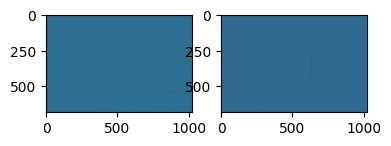

In [6]:
plt.figure()
plt.subplot(131)
plt.imshow(tower_left_harris)
plt.subplot(132)
plt.imshow(tower_right_harris)
plt.show()
# cv2.imshow('1',tower_left_harris)
# cv2.imshow('2',tower_right_harris)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
THRESHOLD = 0.01
PATCH_SIZE = 16
MAX_KEYPOINTS = 10000
# Result is dilated for marking the corners
tower_left_harris_dilated = cv2.dilate(tower_left_harris, None)
tower_right_harris_dilated = cv2.dilate(tower_right_harris, None)

tower_left_keypoints = cv2.threshold(tower_left_harris_dilated, THRESHOLD * tower_left_harris_dilated.max(), 255, cv2.THRESH_BINARY)[1]
tower_left_keypoints = cv2.findNonZero(tower_left_keypoints)
tower_left_keypoints = sorted(tower_left_keypoints, key=lambda p: tower_left_harris_dilated[p[0][1], p[0][0]], reverse=True)[:MAX_KEYPOINTS]
tower_left_keypoints = [cv2.KeyPoint(float(p[0][0]), float(p[0][1]), PATCH_SIZE) for p in tower_left_keypoints]

# If threshold is 0.01, all are 0s
tower_right_keypoints = cv2.threshold(tower_right_harris, THRESHOLD * tower_right_harris.max(), 255, cv2.THRESH_BINARY)[1]
tower_right_keypoints = cv2.findNonZero(tower_right_keypoints)
tower_right_keypoints = sorted(tower_right_keypoints, key=lambda p: tower_right_harris_dilated[p[0][1], p[0][0]], reverse=True)[:MAX_KEYPOINTS]
tower_right_keypoints = [cv2.KeyPoint(float(p[0][0]), float(p[0][1]), PATCH_SIZE) for p in tower_right_keypoints]
print(len(tower_right_keypoints))

# # # # Threshold for an optimal value, it may vary depending on the image.
# tower_left[tower_left_harris_dilated>THRESHOLD*tower_left_harris_dilated.max()]=[0,0,255]
# tower_right[tower_right_harris_dilated>THRESHOLD*tower_right_harris_dilated.max()]=[0,0,255]
 
cv2.imshow('1',tower_left)
cv2.imshow('2',tower_right)
cv2.waitKey(0)
cv2.destroyAllWindows()

10000


In [8]:
# Higher patch size, fewer descriptors
# Lower patch size, smaller size of descriptor
def extract_patches(image, keypoints, patch_size=PATCH_SIZE):
    print(patch_size)
    half_size = patch_size // 2
    descriptors = []

    for point in keypoints:
        x, y = map(int, point.pt)  # Extract coordinates
        if y - half_size >= 0 and y + half_size < image.shape[0] and x - half_size >= 0 and x + half_size < image.shape[1]:
            patch = image[y - half_size:y + half_size, x - half_size:x + half_size]
            descriptors.append(patch.flatten())  # Convert patch to 1D vector

    return descriptors

In [9]:
tower_left_descriptors = extract_patches(tower_left, tower_left_keypoints)
print(len(tower_left_descriptors))

tower_right_descriptors = extract_patches(tower_right, tower_right_keypoints)
print(len(tower_right_descriptors))

128
9348
128
9325


In [10]:
def compute_eucledian_distance(left_descriptors, right_descriptors):
    distance_list = []
    # # dists = np.array([[cv2.norm(d1, d2, cv2.NORM_L2) for d2 in right_descriptors] for d1 in left_descriptors])
    left_descriptors = np.array(left_descriptors)
    right_descriptors = np.array(right_descriptors)
    # # print(left_descriptors.shape)
    # dists = np.linalg.norm(left_descriptors[:, None, :] - right_descriptors[None, :, :], axis=2)
    # return dists


    # for x in left_descriptors:
    #     distances = [cv2.norm(x, y, cv2.NORM_L2) for y in right_descriptors]
    #     distance_list.append(distances)
    # return distance_list

    def test(descriptors):
        min_vals = descriptors.min(axis=1, keepdims=True)
        max_vals = descriptors.max(axis=1, keepdims=True)
        range_vals = max_vals - min_vals + 1e-10  # Avoid division by zero
        return (descriptors - min_vals) / range_vals
    
    left_descriptors = test(left_descriptors)
    right_descriptors = test(right_descriptors)

    return cdist(left_descriptors, right_descriptors, metric='euclidean')

In [11]:
distances = compute_eucledian_distance(tower_left_descriptors, tower_right_descriptors)
print(distances)

[[110.5770036  110.68297662 110.20717867 ... 123.75922713 123.77441227
  123.54798834]
 [110.46551713 110.64737325 110.09490083 ... 123.69449811 123.72763839
  123.47405628]
 [110.35621715 110.5498712  110.00262898 ... 123.66603015 123.72168063
  123.46559334]
 ...
 [110.62828065 110.85988711 110.86096274 ... 108.64054068 108.67253424
  108.73344754]
 [109.63798122 109.89360825 109.98217459 ... 108.11896581 108.15624251
  108.23831793]
 [108.61555253 108.86890677 108.99306137 ... 107.5071532  107.65094652
  107.74358489]]


In [12]:
def select_matches_based_on_threshold(distances, threshold=30):
    matches = []
    for i in range(len(distances)):
        for j in range(len(distances[i])):
            if(distances[i][j] < threshold):
                match = cv2.DMatch(_queryIdx=i, _trainIdx=j, _distance=distances[i][j])
                matches.append(match)
    return matches

In [13]:
matches = select_matches_based_on_threshold(distances)
print(len(matches))

# # Create BFMatcher with L2 norm (for descriptors like SIFT, SURF)
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# # Convert descriptors to float32 (required for BFMatcher)
# left_descriptors = np.array(tower_left_descriptors, dtype=np.float32)
# right_descriptors = np.array(tower_right_descriptors, dtype=np.float32)

# # Match descriptors
# matches = bf.match(left_descriptors, right_descriptors)

# # Sort matches by distance (lower distance = better match)
# matches = sorted(matches, key=lambda x: x.distance)

# # Get the first 100 best matches
# matches = matches[:100]

147


In [14]:
def run_ransac(keypoints1, keypoints2, matches):
    """Estimate Affine and Homography using RANSAC and report inlier count & average residual."""
    
    # Convert keypoints to numpy arrays (float32 for better precision)
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

    def normalize_keypoints(pts):
        mean = np.mean(pts, axis=0)
        std = np.std(pts, axis=0)
        return (pts - mean) / std, mean, std

    pts1_norm, mean1, std1 = normalize_keypoints(pts1)
    pts2_norm, mean2, std2 = normalize_keypoints(pts2)

    # 1️⃣ Estimate Affine Transformation
    affine_matrix, affine_inliers = cv2.estimateAffine2D(pts1_norm, pts2_norm, method=cv2.RANSAC, ransacReprojThreshold=1.0)
    
    if affine_matrix is None:
        print("⚠️ Affine matrix estimation failed!")
        return None, None, None, None
    
    affine_inliers = affine_inliers.ravel().astype(bool)

    # 2️⃣ Estimate Homography
    homography_matrix, homography_inliers = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransacReprojThreshold=1.0)
    
    if homography_matrix is None:
        print("⚠️ Homography estimation failed!")
        return affine_matrix, None, affine_inliers, None
    
    homography_inliers = homography_inliers.ravel().astype(bool)

    # Compute residuals
    def compute_residuals_affine(matrix, pts1, pts2, inliers):
        """Calculate squared distance residuals for affine transformation."""
        transformed_pts = cv2.transform(pts1[inliers].reshape(-1, 1, 2), matrix).reshape(-1, 2)
        residuals = np.linalg.norm(transformed_pts - pts2[inliers], axis=1) ** 2
        return np.mean(residuals)

    def compute_residuals_homography(matrix, pts1, pts2, inliers):
        """Calculate squared distance residuals for homography transformation."""
        transformed_pts = cv2.perspectiveTransform(pts1[inliers].reshape(-1, 1, 2), matrix).reshape(-1, 2)
        residuals = np.linalg.norm(transformed_pts - pts2[inliers], axis=1) ** 2
        return np.mean(residuals)

    affine_residual = compute_residuals_affine(affine_matrix, pts1, pts2, affine_inliers)
    homography_residual = compute_residuals_homography(homography_matrix, pts1, pts2, homography_inliers)

    print(f"Affine: Inliers = {sum(affine_inliers)}, Avg Residual = {affine_residual:.2f}")
    print(f"Homography: Inliers = {sum(homography_inliers)}, Avg Residual = {homography_residual:.2f}")

    return affine_matrix, homography_matrix, affine_inliers, homography_inliers

# Example usage
affine_matrix, homography_matrix, affine_inliers, homography_inliers = run_ransac(
    tower_left_keypoints, tower_right_keypoints, matches
)

Affine: Inliers = 61, Avg Residual = 211260.70
Homography: Inliers = 37, Avg Residual = 27896.99


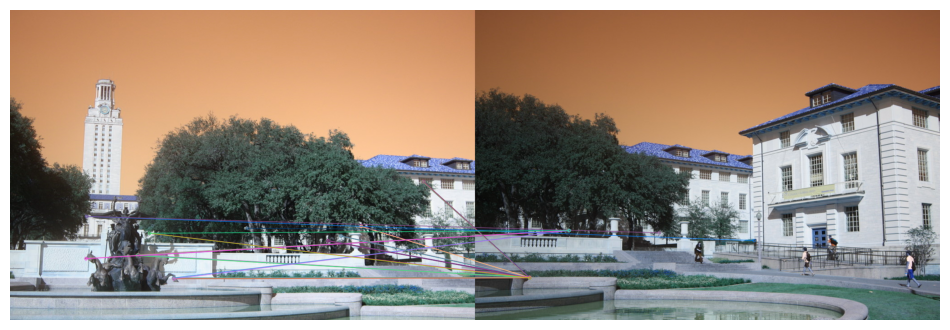

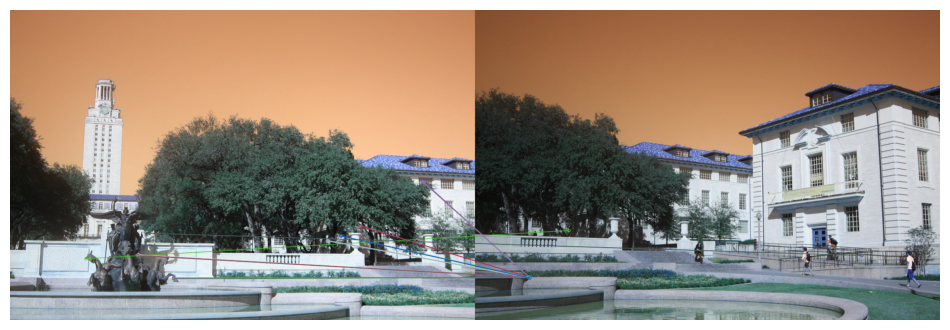

In [15]:
def draw_inliers(img1, kp1, img2, kp2, matches, inliers):
    """Draw inlier matches between two images."""
    inlier_matches = [m for i, m in enumerate(matches) if inliers[i]]
    match_img = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(12, 6))
    plt.imshow(match_img)
    plt.axis("off")
    plt.show()

# Draw affine inliers
draw_inliers(tower_left, tower_left_keypoints, tower_right, tower_right_keypoints, matches, affine_inliers)

# Draw homography inliers
draw_inliers(tower_left, tower_left_keypoints, tower_right, tower_right_keypoints, matches, homography_inliers)

In [16]:
def warp_image_affine(img1, affine_matrix, img2):
    """Warp img1 onto img2 using an affine transformation and blend them."""
    h, w = img2.shape[:2]

    # Warp img1 using affine transformation
    warped_img1 = cv2.warpAffine(img1, affine_matrix, (w, h))
    print(affine_matrix)

    # Create a binary mask for valid pixels in warped_img1
    mask = cv2.cvtColor(warped_img1, cv2.COLOR_BGR2GRAY) > 0  # Ensure it's a single-channel mask
    mask = mask.astype(np.uint8)  # Convert to uint8 (0s and 1s)

    # Blend images
    blended_img = img2.copy()
    blended_img[mask > 0] = warped_img1[mask > 0]

    return blended_img

# Apply affine warping and blending
warped_affine = warp_image_affine(tower_left, affine_matrix, tower_right)

# Show result

[[-0.23096238 -0.16977776 -1.03175869]
 [ 0.38644688  0.18334894  0.66413192]]


In [17]:
def warp_image_homography(img1, homography_matrix, img2):
    """Warp img1 onto img2 using homography transformation."""
    h, w = img2.shape[:2]
    warped_img = cv2.warpPerspective(img1, homography_matrix, (w, h))
    
    return warped_img

warped_homography = warp_image_homography(tower_left, homography_matrix, tower_right)

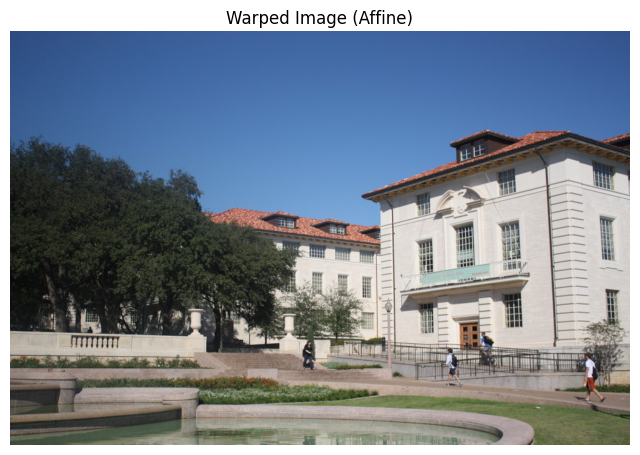

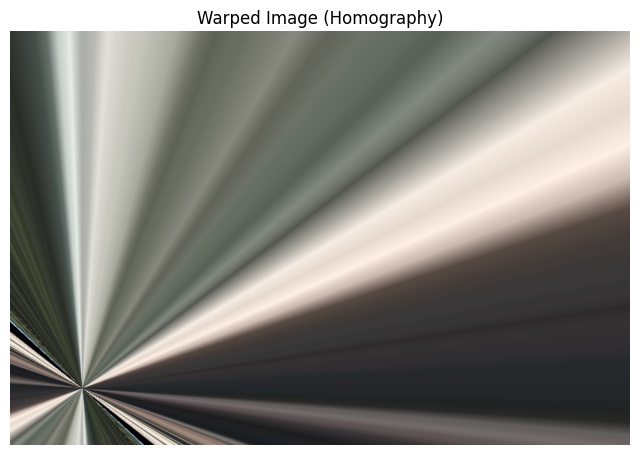

In [18]:
def show_image(title, img):
    """Display an image using Matplotlib."""
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Show both warped images
show_image("Warped Image (Affine)", warped_affine)
show_image("Warped Image (Homography)", warped_homography)